In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

In [28]:
def read_and_create_data(filename):
    if filename == 'Iris.csv':
        
        df = pd.read_csv(filename)
        df2 = df.join(pd.get_dummies(df.pop('Species')))

        np.random.seed(9)
        df_train = df2
        df_test = df2
        _Y = df_train[df_train.columns[-3:]]
        _X = df_train[df_train.columns[:4]].apply(
            lambda x: (x - x.min())/(x.max() - x.min()))

        y_test = df_test[df_test.columns[-3:]]
        X_test = df_test[df_test.columns[:4]].apply(
            lambda x: (x - x.min())/(x.max() - x.min()))

        return _X, _Y, X_test, y_test
    else:
        df = pd.read_csv(filename)
        np.random.seed(9)
        df_train = df
        df_test = df
        _Y = df_train[df_train.columns[-1:]]
        _X = df_train[df_train.columns[:13]].apply(
            lambda x: (x-x.min())/(x.max()-x.min()))
        y_test = df_test[df_test.columns[-1:]]
        X_test = df_test[df_test.columns[:13]].apply(
            lambda x: (x - x.min())/(x.max() - x.min()))

        return _X, _Y, X_test, y_test

def leer_datos(dataset):
    data = pd.read_csv(dataset) 
    x = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    return x,y

def normalizar_datos(x):
    x_media = x.mean(axis=0)
    x_std = x.std(axis=0)
    x  = (x - x_media)/x_std
    return x

def dividir_datos(X, y, porcentaje):
    X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=porcentaje, random_state=42)
    return X_train, X_test, y_train, y_test



In [114]:
from sklearn.model_selection import train_test_split
_X1, _y1, _X_test1, _y_test1 = read_and_create_data('heart.csv')
_X, _X_test, _y, _y_test = train_test_split( _X1, _y1, test_size=0.30, random_state=42)


In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(x):
    return x * (1.0 - x)

In [31]:
class HiddenLayer(object):
    def __init__(self, n_input, n_output, function_activation,
                 last_layer=False, W=None, b=None):
        self.n_input = n_input
        self.n_output = n_output
        self.function_activation = function_activation
        self.W = W
        self.b = b
        self.last_layer = last_layer
        if not self.W:
            # Random Weights
            # self.W = np.random.normal(0,1,(n_input, n_output))
            # self.W = normalize(self.W)
            self.W = 2.0*np.random.random((n_input, n_output))-1.0
            self.W /= np.sqrt(n_input)
            # self.W = np.amax(np.random.normal(0,1,(n_input, n_output)), axis=0)
        if not self.b:
            self.b = 2.0*np.random.random((1, n_output))-1.0

        
    def get_activations(self, input, penum=False):
        self.activations = self.function_activation(
            np.dot(input, self.W))
        return self.activations

In [32]:
class MLP(object):
    def __init__(self, n_hidden_layers, n_activations, n_input, n_output):
        self.n_hidden_layers = n_hidden_layers
        self.n_activations = n_activations
        self.n_input = n_input
        self.function_activation = sigmoid
        self.function_derivative = sigmoid_derivative
        # Add first layer

        self.hidden_layers = [
            HiddenLayer(
                self.n_input,
                self.n_activations,
                self.function_activation
            )
        ]
        # print(self.hidden_layers[0].W.shape)
        for i in range(self.n_hidden_layers-1):
            layer_to_append = HiddenLayer(
                # how n_input use the size of columns of
                # the weights in the last layer
                self.n_activations,
                self.n_activations,
                self.function_activation
            )
            self.hidden_layers.append(layer_to_append)

        # Add last layer
        self.hidden_layers.append(
            HiddenLayer(
                self.n_activations,
                n_output,
                sigmoid,
                last_layer=True
            )
        )

    def forward(self, input, activations=list(), final_activations=list()):
        activations.append(input)
        last_activation = input
        final_activations.append(last_activation)

        for hidden_layer in self.hidden_layers[:-1]:
            last_activation = hidden_layer.get_activations(last_activation)
            activations.append(last_activation)
        #    last_activation = np.append(np.array([1.0]), last_activation)
            final_activations.append(last_activation)

        last_activation = self.hidden_layers[-1].get_activations(
            last_activation)
        activations.append(last_activation)

        return last_activation

    def calculate_cost(self, X, y):
        y_pred_test = self.forward(X)
        first_to_sum = y * np.log(y_pred_test)
        second_to_sum = (1 - y) * np.log(1 - y_pred_test)
        to_sum = first_to_sum + second_to_sum
        return (-(1/(X.shape[0])) * np.sum(to_sum)).mean()

    def sklearn_cost(self, X, y):
        y_pred_test = np.apply_along_axis(self.forward, 1, X)
        return log_loss(y, y_pred_test)

    def backward(self, X, y):
        activations = []
        final_activations = []
        tmp_forward = self.forward(X, activations, final_activations)

        deltas = []
        current_activation = activations[len(activations)-1]
        current_update_activation = activations[len(activations)-2]
        last_delta = (y - current_activation) * self.function_derivative(
            current_activation)
        deltas.append(np.dot(current_update_activation.T, last_delta))
        activations.pop()
        for hidden_layer in reversed(self.hidden_layers[1:]):
            current_activation = activations[len(activations) - 1]
            current_update_activation = activations[len(activations) - 2]
            last_delta = np.dot(
                last_delta, hidden_layer.W.T
            ) * self.function_derivative(current_activation)
            deltas.append(np.dot(current_update_activation.T, last_delta))
            activations.pop()
        deltas.reverse()
        return deltas



In [33]:
def plot_cost_history(iterations, cost_history):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_ylabel('J(Theta)')
    ax.set_xlabel('Iterations')
    _ = ax.plot(range(iterations), cost_history, 'g.')
    plt.show()

In [115]:
mlp = MLP(1, 10, 13, 1)
learning_rate = 0.07
iterations = 1000

In [116]:
cost_history = np.zeros(iterations)
last_error = mlp.calculate_cost(_X, _y)
accuracyPromedio = []
def precision(_X_test, _y_test, filename):
    index = 0
    assertsArray = []
    asserts = 0
    _X_test = normalizar_datos(_X_test)
    for x, y in zip(_X_test.values, _y_test.values):
        if filename == "Iris.csv":
            predicted = mlp.forward(x)
            print(predicted)
            predicted[0] = 1 if predicted[0] > 0.5 else 0
            predicted[1] = 1 if predicted[1] > 0.5 else 0
            predicted[2] = 1 if predicted[2] > 0.5 else 0
            print(predicted, y)
            if (y == predicted).all():
                asserts += 1
        else:
            predicted = mlp.forward(x)
            print(predicted)
            predicted[0] = 1 if predicted[0] > 0.5 else 0
            print(predicted, y)
            if (y == predicted).all():
                asserts += 1
    assertsArray.append(asserts/_X_test.shape[0])
    index = index + 1
    return assertsArray

def experimento(model, learning_rate, iterations, filename, last_error, cost_history):
    indexFor = 0;
    n_csv = 0
    while indexFor < 3:
        if filename == "Iris.csv":
            _X = TrainProbandoX = pd.read_csv('foldsIris' + str(n_csv) + '.csv', usecols = ['0', '1', '2', '3'])
            _y = TrainProbandoY = pd.read_csv('foldsIris' + str(n_csv+1) + '.csv', usecols = ['0'])
            _X_test = pd.read_csv('foldsIris' +  str(n_csv+2)+'.csv', usecols = ['0', '1', '2', '3'])
            _y_test = pd.read_csv('foldsIris' + str(n_csv+3) + '.csv', usecols = ['0'])

            _y = _y.join(pd.get_dummies(_y.pop('0')))
            _y_test = _y_test.join(pd.get_dummies(_y_test.pop('0')))

            _X = normalizar_datos(_X)
            for itr in range(iterations):
                _X, _y = shuffle(_X, _y, random_state=1)
                deltas = mlp.backward(_X, _y)
                index = len(mlp.hidden_layers) - 1
                while index >= 0:
                    mlp.hidden_layers[index].W += (deltas[index] * learning_rate)
                    index -= 1
                last_error = mlp.calculate_cost(_X, _y)
                cost_history[itr] = last_error
            accuracyPromedio.append(precision(_X_test, _y_test, "Iris.csv"))
            indexFor = indexFor+1
            n_csv = n_csv + 4
        else:
            _X = TrainProbandoX = pd.read_csv('folds' + str(n_csv) + '.csv', usecols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
            _y = TrainProbandoY = pd.read_csv('folds' + str(n_csv+1) + '.csv', usecols = ['0'])
            _X_test = pd.read_csv('folds' +  str(n_csv+2)+'.csv', usecols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
            _y_test = pd.read_csv('folds' + str(n_csv+3) + '.csv', usecols = ['0'])

            _X = normalizar_datos(_X)
            for itr in range(iterations):
                _X, _y = shuffle(_X, _y, random_state=1)
                deltas = mlp.backward(_X, _y)
                index = len(mlp.hidden_layers) - 1
                while index >= 0:
                    mlp.hidden_layers[index].W += (deltas[index] * learning_rate)
                    index -= 1
                last_error = mlp.calculate_cost(_X, _y)
                cost_history[itr] = last_error
            accuracyPromedio.append(precision(_X_test, _y_test, "heart.csv"))
            indexFor = indexFor+1
            n_csv = n_csv + 4

In [117]:
experimento(mlp, learning_rate, iterations, "heart.csv", last_error, cost_history)

[0.95682638]
[1.] [1]
[0.88417949]
[1.] [1]
[0.9803538]
[1.] [1]
[0.99430482]
[1.] [1]
[0.96731915]
[1.] [1]
[0.84324596]
[1.] [1]
[0.96551444]
[1.] [1]
[0.99922504]
[1.] [1]
[0.78387109]
[1.] [1]
[0.99945721]
[1.] [1]
[0.18979042]
[0.] [1]
[0.99818763]
[1.] [1]
[0.99429978]
[1.] [1]
[0.99919615]
[1.] [1]
[0.93372195]
[1.] [1]
[0.99978806]
[1.] [1]
[0.99651677]
[1.] [1]
[0.60043362]
[1.] [1]
[0.63065626]
[1.] [1]
[0.99953942]
[1.] [1]
[0.51614236]
[1.] [1]
[0.99616339]
[1.] [1]
[0.97374425]
[1.] [1]
[0.43287444]
[0.] [1]
[0.074526]
[0.] [1]
[0.24900482]
[0.] [1]
[0.98012795]
[1.] [1]
[0.97635605]
[1.] [1]
[0.39574988]
[0.] [1]
[0.93704798]
[1.] [1]
[0.9951435]
[1.] [1]
[0.45204016]
[0.] [1]
[0.98496629]
[1.] [1]
[0.30887735]
[0.] [1]
[0.24515848]
[0.] [1]
[0.99529482]
[1.] [1]
[0.99005041]
[1.] [1]
[0.42050862]
[0.] [1]
[0.8751746]
[1.] [1]
[0.57600855]
[1.] [1]
[0.40315093]
[0.] [1]
[0.82328409]
[1.] [1]
[0.19671368]
[0.] [1]
[0.72169193]
[1.] [1]
[0.91241388]
[1.] [1]
[0.97995748]
[1

In [69]:
# _X = normalizar_datos(_X)
# for itr in range(iterations):
#     _X, _y = shuffle(_X, _y, random_state=1)
#     deltas = mlp.backward(_X, _y)
#     index = len(mlp.hidden_layers) - 1
#     while index >= 0:
#         mlp.hidden_layers[index].W += (deltas[index] * learning_rate)
#         index -= 1
#     last_error = mlp.calculate_cost(_X, _y)
#     cost_history[itr] = last_error

[[0.7227722772277227], [0.9207920792079208], [0.9405940594059405]]
0.8613861386138614


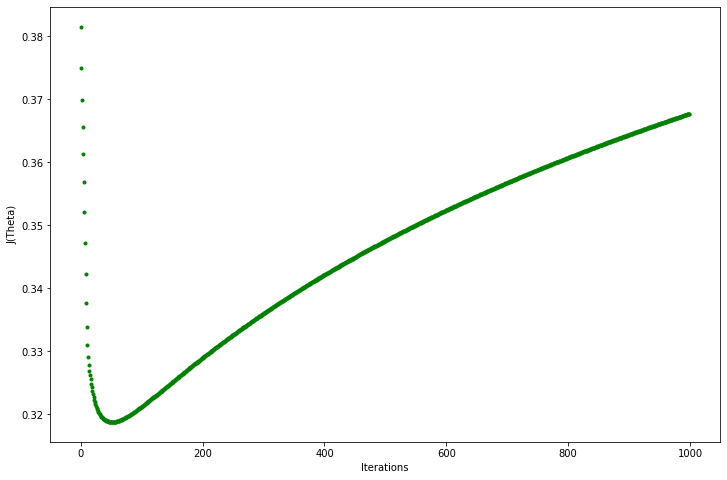

In [118]:

print (accuracyPromedio)
def promedioAccuracy (accuracyPromedio):
    promedio = 0
    for index in accuracyPromedio:
        promedio = promedio + index[0]
    print (promedio / len(accuracyPromedio))
promedioAccuracy(accuracyPromedio)
# asserts = 0
# _X_test = normalizar_datos(_X_test)
# for x, y in zip(_X_test.values, _y_test.values):
#     predicted = mlp.forward(x)
#     print(predicted)
#     predicted[0] = 1 if predicted[0] > 0.5 else 0
#     predicted[1] = 1 if predicted[1] > 0.5 else 0
#     predicted[2] = 1 if predicted[2] > 0.5 else 0
#     print(predicted, y)
#     if (y == predicted).all():
#         asserts += 1
# print(asserts/_X_test.shape[0])
plot_cost_history(iterations, cost_history)

# asserts = 0
# _X_test = normalizar_datos(_X_test)
# for x, y in zip(_X_test.values, _y_test.values):
#     predicted = mlp.forward(x)
#     print(predicted)
#     predicted[0] = 1 if predicted[0] > 0.5 else 0
#     print(predicted, y)
#     if (y == predicted).all():
#         asserts += 1
# print(asserts/_X_test.shape[0])
# plot_cost_history(iterations, cost_history)
